In [ ]:
!pip install flwr

In [ ]:
import os
import sys
import timeit
from collections import OrderedDict
from typing import Dict, List, Tuple
import numpy as np
import matplotlib.pyplot as plt

from random import random, randint, sample, choice


import torch
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10


import flwr as fl


In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Data Creation

In [ ]:
PARTY_TYPE = "Minor"
THRESHOLD = 0.7

if random()  > THRESHOLD:
    PARTY_TYPE = "MAJOR"

if PARTY_TYPE == "MAJOR":
    obs  = randint(10000,15000)
else:
    obs  = randint(2000,3000)
    

print ("Welcome, You are a {ptype} Client. \nYou have {n_obs} records in your dataset.".format(ptype = PARTY_TYPE, n_obs=obs))

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = sample(list(CIFAR10(".", train=True, download=True, transform=transform)),obs)
testset = CIFAR10(".", train=False, download=True, transform=transform)


trainloader = DataLoader(trainset, batch_size=8, shuffle=True)
testloader = DataLoader(testset, batch_size=8)

Welcome, You are a Minor Client. 
You have 2286 records in your dataset.



Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

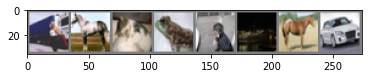

truck horse   cat  frog   dog  ship horse   car


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = dataiter.next()

### show images
imshow(torchvision.utils.make_grid(images))
### print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(8)))

In [ ]:
### Class Distribution FOR TRAIN
count = {item : 0 for item in classes}
for data in iter(trainset):
    count[classes[data[1]]] += 1

print(count)

{'plane': 204, 'car': 277, 'bird': 223, 'cat': 221, 'deer': 196, 'dog': 220, 'frog': 259, 'horse': 243, 'ship': 231, 'truck': 212}


In [ ]:
class Net(torch.nn.Module):

    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 6, 5)
        self.pool = torch.nn.MaxPool2d(2, 2)
        self.conv2 = torch.nn.Conv2d(6, 16, 5)
        self.fc1 = torch.nn.Linear(16 * 5 * 5, 120)
        self.fc2 = torch.nn.Linear(120, 84)
        self.fc3 = torch.nn.Linear(84, 10)

    ### pylint: disable=arguments-differ,invalid-name
    def forward(self, x: Tensor) -> Tensor:
        """Compute forward pass."""
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
def train(
    net: None,
    trainloader: torch.utils.data.DataLoader,
    epochs: int,
    device: torch.device,
) -> None:
    
    """Train the network."""
    ### Define loss and optimizer
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

    print(f"Training {epochs} epoch(s) w/ {len(trainloader)} batches each")

    ### Train the network
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(trainloader, 0):
            images, labels = data[0].to(device), data[1].to(device)

            ### zero the parameter gradients
            optimizer.zero_grad()

            ### forward + backward + optimize
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            ### print statistics
            running_loss += loss.item()
            if i % 100 == 99:  # print every 100 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0

In [ ]:
def test(
    net: None,
    testloader: torch.utils.data.DataLoader,
    device: torch.device,
) -> Tuple[float, float]:
    
    """Validate the network on the entire test set."""
    
    criterion = torch.nn.CrossEntropyLoss()
    correct = 0
    total = 0
    loss = 0.0
    
    with torch.no_grad():
        
        for data in testloader:
            
            images, labels = data[0].to(device), data[1].to(device)
            
            outputs = net(images)
            
            loss += criterion(outputs, labels).item()
            
            _, predicted = torch.max(outputs.data, 1)
            
            total += labels.size(0)
            
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    
    return loss, accuracy

#### Centralized Modeling on your own data


In [ ]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Centralized PyTorch training")

c_model = Net()

print("Start training")
train(net=c_model, trainloader=trainloader, epochs=2, device=DEVICE)

print("Evaluate model")
loss, accuracy = test(net=c_model, testloader=testloader, device=DEVICE)


print("Loss: ", loss)
print("Accuracy: ", accuracy)

### Federated Learning

In [ ]:
# Flower Client
class CifarClient(fl.client.NumPyClient):
    """Flower client implementing CIFAR-10 image classification using
    PyTorch."""

    def __init__(
        self,
        model: None,
        trainloader: torch.utils.data.DataLoader,
        testloader: torch.utils.data.DataLoader,
    ) -> None:
        
        self.model = model
        self.trainloader = trainloader
        self.testloader = testloader

    def get_parameters(self) -> List[np.ndarray]:
        ### Return model parameters to server as a list of NumPy ndarrays

        return [val.cpu().numpy() for _, val in self.model.state_dict().items()]
    

    
    def set_parameters(self, parameters: List[np.ndarray]) -> None:
        ### Set model parameters in client from a list of NumPy ndarrays
        
        params_dict = zip(self.model.state_dict().keys(), parameters)
        state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
        
        self.model.load_state_dict(state_dict, strict=True)
        

    
    def fit(
        self, parameters: List[np.ndarray], config: Dict[str, str]
    ) -> Tuple[List[np.ndarray], int]:
        ### Set model parameters, train model in client and return updated model parameters to server
        
        self.set_parameters(parameters)
        
        train(self.model, self.trainloader, epochs=1, device=DEVICE)
        
        return self.get_parameters(), len(self.trainloader), {}
    

    
    
    def evaluate(
        self, parameters: List[np.ndarray], config: Dict[str, str]
    ) -> Tuple[int, float, float]:
        ### Set model parameters, evaluate model on local test dataset in client and return result to server
        
        self.set_parameters(parameters)
        
        loss, accuracy = test(self.model, self.testloader, device=DEVICE)
        
        return float(loss), len(self.testloader), {"accuracy": float(accuracy)}

#### Scotty, Beam Me Up

In [ ]:
SERVER_IP = "100.110.225.209"
SERVER_PORT = "8080"
SERVER_ADDRESS = "{ip}:{port}".format(ip=SERVER_IP, port=SERVER_PORT)

In [ ]:
print("Connected to server at {serverAddress}".format(serverAddress=SERVER_ADDRESS))

# Load model and data
f_model = Net().to(DEVICE)

client = CifarClient(f_model, trainloader, testloader)

fl.client.start_numpy_client(SERVER_ADDRESS, client)

In [ ]:
loss, accuracy = test(net=f_model, testloader=testloader, device=DEVICE)
print("Loss: ", loss)
print("Accuracy: ", accuracy)